# **Task 3** 👉 **Embedding with text**

# **Setup**

## Imports and disk connection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
from datetime import datetime

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder

import nltk
from nltk.tokenize import word_tokenize
from collections import Counter, defaultdict

from sentence_transformers import SentenceTransformer


from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Options: 'normal', 'residual', 'transformer'

MODEL = 'transformer'

## Load data from disk

In [4]:
# DATA
DATA_PATH = 'drive/My Drive/Job_salary_prediction/Data/'

TRAIN_PATH = DATA_PATH + 'train_clean_with_text.csv'
VAL_PATH = DATA_PATH + 'val_clean_with_text.csv'
TEST_PATH = DATA_PATH + 'test_clean_with_text.csv'

# TRAIN_PATH = 'train_clean_with_text.csv'
# VAL_PATH = 'val_clean_with_text.csv'
# TEST_PATH = 'test_clean_with_text.csv'

In [5]:
train_df = pd.read_csv(TRAIN_PATH)
val_df = pd.read_csv(VAL_PATH)
test_df = pd.read_csv(TEST_PATH)

X_train = train_df.drop('SalaryNormalized', axis=1)
y_train = train_df['SalaryNormalized']

X_val = val_df.drop('SalaryNormalized', axis=1)
y_val = val_df['SalaryNormalized']

X_test = test_df.drop('SalaryNormalized', axis=1)
y_test = test_df['SalaryNormalized']

## Log transform

In [6]:
y_train = np.log1p(y_train)
y_val = np.log1p(y_val)
y_test = np.log1p(y_test)

## Label encoding

In [7]:
encoders = {}
X_train_encoded = X_train.copy()
X_val_encoded = X_val.copy()
X_test_encoded = X_test.copy()

for col in X_train.columns:
  if col != 'FullDescription':
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train[col])
    X_val_encoded[col] = le.transform(X_val[col])
    X_test_encoded[col] = le.transform(X_test[col])
    encoders[col] = le

## Check length of FullDescriptions

In [8]:
X_train['FullDescription'].apply(lambda x: len(x.split())).describe()

,FullDescription
count,172683.000000
mean,244.775137
std,130.096261
min,4.000000
25%,154.000000
50%,226.000000
75%,312.000000
max,2113.000000


<Axes: xlabel='FullDescription', ylabel='Count'>

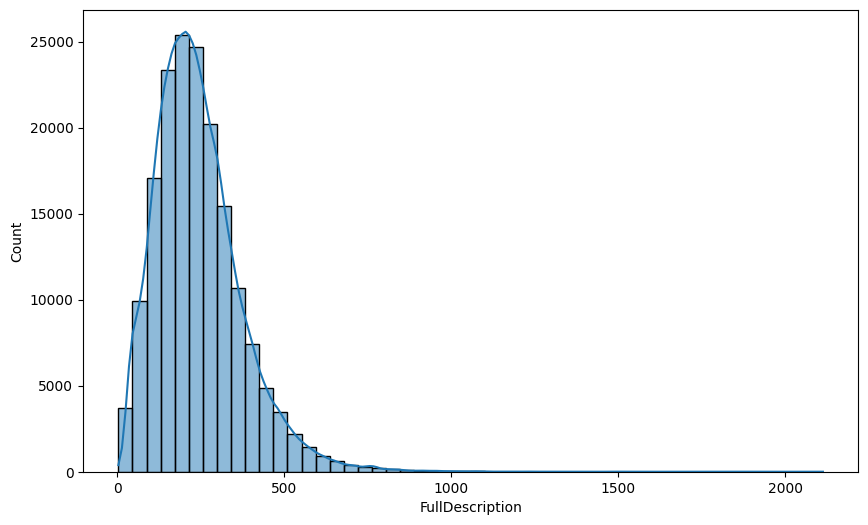

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(X_train['FullDescription'].apply(lambda x: len(x.split())), bins=50, kde=True)

## Tokenizing

In [10]:
def build_vocab(series, min_freq=2):
    counter = Counter()

    for text in series:
        tokens = word_tokenize(str(text).lower())
        counter.update(tokens)
        # character_tokens = list(text.lower())
        # character_filtered = [token for token in character_tokens if token.isalnum()]
        # counter.update(character_filtered)

    vocab = {'<PAD>': 0, '<UNK>': 1}
    index = 2

    for token, freq in counter.items():
        if freq >= min_freq:
            vocab[token] = index
            index += 1

    return vocab


def encode_text(text, vocab, max_len):

    tokens = word_tokenize(str(text).lower())
    token_ids = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    token_ids = token_ids[:max_len]
    # pad if needed
    if len(token_ids) < max_len:
        token_ids += [vocab['<PAD>']] * (max_len - len(token_ids))
    return token_ids

## Dataset and DataLoader

In [11]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

In [12]:
class JobDataset(Dataset):
    def __init__(self, X, y, full_descs, vocab, max_len=100):
        if 'FullDescription' in X.columns:
            X = X.drop(columns=['FullDescription'])

        self.X = torch.tensor(X.values, dtype=torch.long)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)
        self.full_descs = [torch.tensor(encode_text(desc, vocab, max_len)) for desc in full_descs]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (self.X[idx], self.full_descs[idx]), self.y[idx]

In [13]:
# transformation to use inside TransformerDataset
class SentenceTransformation:
    def __init__(self, device, model_name='sentence-transformers/all-MiniLM-L12-v2'):
      self.model = SentenceTransformer(model_name)
      self.model.eval()
      self.device = device
      self.model.to(self.device)

    def __call__(self, text):
      with torch.no_grad():
        emb = self.model.encode(text, convert_to_tensor=True, device=self.device, prompt=None)
      return emb


class TransformerDataset(Dataset):
    def __init__(self, X, y, full_descs, device, transform=None):
        if 'FullDescription' in X.columns:
            X = X.drop(columns=['FullDescription'])

        self.device = device
        self.X = torch.tensor(X.values, dtype=torch.long).to(self.device)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1).to(self.device)
        self.transform = transform
        self.full_descs = self.transform(full_descs).to(self.device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (self.X[idx], self.full_descs[idx]), self.y[idx]

In [14]:
SEED = 42
BATCH_SIZE=64

In [15]:
if MODEL != 'transformer':
  nltk.download('punkt_tab')

  vocab = build_vocab(pd.concat([X_train['FullDescription'], X_val['FullDescription'], X_test['FullDescription']]), min_freq=2)
  vocab_size = len(vocab)

In [16]:
if MODEL == 'transformer':
  TEXT_EMB_DIM = 384
else:
  TEXT_EMB_DIM = 32
MAX_LEN = 75

In [17]:
set_seed(SEED)

if MODEL == 'transformer':
  transformer = SentenceTransformation(device=DEVICE)
  train_dataset = TransformerDataset(X_train_encoded, y_train, X_train['FullDescription'],DEVICE, transform=transformer)
  val_dataset = TransformerDataset(X_val_encoded, y_val, X_val['FullDescription'], DEVICE, transform=transformer)
  test_dataset = TransformerDataset(X_test_encoded, y_test, X_test['FullDescription'], DEVICE, transform=transformer)

else:
  train_dataset = JobDataset(X_train_encoded, y_train, X_train['FullDescription'], vocab, MAX_LEN)
  val_dataset = JobDataset(X_val_encoded, y_val, X_val['FullDescription'], vocab, MAX_LEN)
  test_dataset = JobDataset(X_test_encoded, y_test, X_test['FullDescription'], vocab, MAX_LEN)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [18]:
# get unique values for each column
# category_sizes = [len(train_df[col].unique()) for col in train_df.columns[:-1]]

category_sizes = [X_train_encoded[col].max() + 1 for col in X_train_encoded.columns if col != 'FullDescription']


category_sizes

[1000, 3, 3, 1001, 29]

In [19]:
embed_dims = [min(50, (cat_size + 1) // 2) for cat_size in category_sizes]
# embed_dims = [15, 15, 5, 2, 2]

embed_dims

[50, 2, 2, 50, 15]

# **Model**

Model with embedding

In [119]:
class EmbedModel(nn.Module):
    def __init__(self, category_sizes, embed_dims, vocab_size, text_emb_dim, max_len):
        super(EmbedModel, self).__init__()

        # Categorical embeddings
        self.embeddings = nn.ModuleList([
            nn.Embedding(cat_size, dim)
            for cat_size, dim in zip(category_sizes, embed_dims)
        ])
        total_cat_emb_size = sum(embed_dims)

        # Text embedding
        self.text_embedding = nn.Embedding(vocab_size, text_emb_dim, padding_idx=0)
        self.max_len = max_len

        conv_output_dim = 32

        self.conv1 = nn.Conv1d(
            in_channels=text_emb_dim,
            out_channels=conv_output_dim,
            kernel_size=3,
            padding=1
        )

        self.conv2 = nn.Conv1d(
            in_channels=conv_output_dim,
            out_channels=conv_output_dim,
            kernel_size=3,
            padding=1
        )

        total_input_size = total_cat_emb_size + text_emb_dim

        self.bn0 = nn.BatchNorm1d(total_input_size)
        self.fc_input = nn.Linear(total_input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.ln1 = nn.LayerNorm(128)
        self.dropout1 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.ln2 = nn.LayerNorm(64)
        self.dropout2 = nn.Dropout(0.1)

        self.fc2 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.ln3 = nn.LayerNorm(32)
        self.dropout3 = nn.Dropout(0.1)

        self.fc_output = nn.Linear(32, 1)

    def forward(self, inputs):
        cat_input, text_input = inputs  # (batch, num_cats), (batch, max_len)

        cat_embeds = [emb(cat_input[:, i]) for i, emb in enumerate(self.embeddings)]
        cat_x = torch.cat(cat_embeds, dim=1)

        # text_emb = self.text_embedding(text_input)  # (batch, max_len, emb_dim)
        # text_x = torch.mean(text_emb, dim=1)  # (batch, emb_dim)

        # Text Embedding
        text_emb = self.text_embedding(text_input)  # (batch, seq_len, embed_dim)

        # Conv1D needs (batch, channels, length)
        text_emb = text_emb.permute(0, 2, 1)  # (batch, embed_dim, seq_len)

        text_conv = F.relu(self.conv1(text_emb))  # (batch, conv_output_dim, seq_len)
        text_conv = F.adaptive_avg_pool1d(text_conv, 1).squeeze(-1)  # (batch, conv_output_dim, 1)
        # text_conv = F.max_pool1d(text_conv, kernel_size=text_conv.size(2))  # (batch, conv_output_dim, 1)

        # text_conv = F.relu(self.conv2(text_conv))
        # text_conv = F.max_pool1d(text_conv, kernel_size=text_conv.size(2)).squeeze(-1)

        x = torch.cat([cat_x, text_conv], dim=1)
        x = self.bn0(x)
        x = F.relu(self.ln1(self.fc_input(x)))
        x = self.dropout1(x)

        x = F.relu(self.ln2(self.fc1(x)))
        x = self.dropout2(x)

        x = F.relu(self.ln3(self.fc2(x)))
        x = self.dropout3(x)

        x = self.fc_output(x)

        return x

Model using Residual Connections between the blocks

In [120]:
class ResidualBlock(nn.Module):
  def __init__(self, input_dim, output_dim, dropout_rate):
    super(ResidualBlock, self).__init__()
    self.block = nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LayerNorm(output_dim),
        nn.ReLU(),
        nn.Dropout(dropout_rate)
    )

    self.shortcut = (
        nn.Identity() if input_dim == output_dim
        else nn.Sequential(nn.Linear(input_dim, output_dim), nn.LayerNorm(output_dim))
        )

  def forward(self, x):
    return self.shortcut(x) + self.block(x)



class ResEmbedModel(nn.Module):
    def __init__(self, category_sizes, embed_dims, vocab_size, text_emb_dim, max_len):
        super(ResEmbedModel, self).__init__()

        self.embeddings = nn.ModuleList([
            nn.Embedding(cat_size, dim)
            for cat_size, dim in zip(category_sizes, embed_dims)
        ])
        total_cat_emb_size = sum(embed_dims)

        # Text embedding
        self.text_embedding = nn.Embedding(vocab_size, text_emb_dim, padding_idx=0)
        self.max_len = max_len

        conv_output_dim = 32

        self.conv1 = nn.Conv1d(
            in_channels=text_emb_dim,
            out_channels=conv_output_dim,
            kernel_size=3,
            padding=1
        )

        total_input_size = total_cat_emb_size + text_emb_dim

        self.bn0 = nn.BatchNorm1d(total_input_size)

        self.res_block1 = ResidualBlock(total_input_size, 128, 0.1)
        self.res_block2 = ResidualBlock(128, 128, 0.1)

        self.res_block3 = ResidualBlock(128, 64, 0.1)
        self.res_block4 = ResidualBlock(64, 64, 0.1)

        self.res_block5 = ResidualBlock(64, 32, 0.1)
        self.res_block6 = ResidualBlock(32, 32, 0.1)

        self.fc_output = nn.Linear(32, 1)


    def forward(self, inputs):
        cat_input, text_input = inputs  # (batch, num_cats), (batch, max_len)

        cat_embeds = [emb(cat_input[:, i]) for i, emb in enumerate(self.embeddings)]
        cat_x = torch.cat(cat_embeds, dim=1)

        # text_emb = self.text_embedding(text_input)  # (batch, max_len, emb_dim)
        # text_x = torch.mean(text_emb, dim=1)  # (batch, emb_dim)

        # Text Embedding
        text_emb = self.text_embedding(text_input)  # (batch, seq_len, embed_dim)

        # Conv1D needs (batch, channels, length)
        text_emb = text_emb.permute(0, 2, 1)  # (batch, embed_dim, seq_len)

        text_conv = F.relu(self.conv1(text_emb))  # (batch, conv_output_dim, seq_len)
        text_conv = F.adaptive_avg_pool1d(text_conv, 1).squeeze(-1)  # (batch, conv_output_dim, 1)
        # text_conv = F.max_pool1d(text_conv, kernel_size=text_conv.size(2))  # (batch, conv_output_dim, 1)

        # text_conv = F.relu(self.conv2(text_conv))
        # text_conv = F.max_pool1d(text_conv, kernel_size=text_conv.size(2)).squeeze(-1)

        x = torch.cat([cat_x, text_conv], dim=1)
        x = self.bn0(x)

        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        x = self.res_block4(x)
        x = self.res_block5(x)
        x = self.res_block6(x)

        x = self.fc_output(x)

        return x

Model using sentence trasformers

In [121]:
# CODE FOR THE SENTENCE TRANSFORMERS MODEL :))

class TransformerModel(nn.Module):
    def __init__(self, category_sizes, embed_dims, text_emb_dim):
        super(TransformerModel, self).__init__()

        # Embeddings for categorical features
        self.embeddings = nn.ModuleList([
            nn.Embedding(cat_size, dim)
            for cat_size, dim in zip(category_sizes, embed_dims)
        ])
        total_cat_emb_size = sum(embed_dims)

        total_input_size = total_cat_emb_size + text_emb_dim

        self.bn0 = nn.BatchNorm1d(total_input_size)

        self.res_block1 = ResidualBlock(total_input_size, 128, 0.1)
        self.res_block2 = ResidualBlock(128, 128, 0.1)

        self.res_block3 = ResidualBlock(128, 64, 0.1)
        self.res_block4 = ResidualBlock(64, 64, 0.1)

        self.res_block5 = ResidualBlock(64, 32, 0.1)
        self.res_block6 = ResidualBlock(32, 32, 0.1)

        self.fc_output = nn.Linear(32, 1)

    def forward(self, inputs):
        cat_input, text_emb = inputs  # text_emb: (batch, emb_dim)

        cat_embeds = [emb(cat_input[:, i]) for i, emb in enumerate(self.embeddings)]
        cat_x = torch.cat(cat_embeds, dim=1)

        x = torch.cat([cat_x, text_emb], dim=1)

        x = self.bn0(x)

        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        x = self.res_block4(x)
        x = self.res_block5(x)
        x = self.res_block6(x)

        x = self.fc_output(x)

        return x

In [122]:
set_seed(SEED)

if MODEL == 'normal':

  model = EmbedModel(
      category_sizes=category_sizes,
      embed_dims=embed_dims,
      vocab_size=vocab_size,
      text_emb_dim=TEXT_EMB_DIM,
      max_len=MAX_LEN
  ).to(DEVICE)

elif MODEL == 'residual':

  model = ResEmbedModel(
      category_sizes=category_sizes,
      embed_dims=embed_dims,
      vocab_size=vocab_size,
      text_emb_dim=TEXT_EMB_DIM,
      max_len=MAX_LEN
  ).to(DEVICE)

elif MODEL == 'transformer':

  model = TransformerModel(
      category_sizes=category_sizes,
      embed_dims=embed_dims,
      text_emb_dim=TEXT_EMB_DIM
  ).to(DEVICE)


print(model)

TransformerModel(
  (embeddings): ModuleList(
    (0): Embedding(1000, 50)
    (1-2): 2 x Embedding(3, 2)
    (3): Embedding(1001, 50)
    (4): Embedding(29, 15)
  )
  (bn0): BatchNorm1d(503, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res_block1): ResidualBlock(
    (block): Sequential(
      (0): Linear(in_features=503, out_features=128, bias=True)
      (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
    )
    (shortcut): Sequential(
      (0): Linear(in_features=503, out_features=128, bias=True)
      (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
  )
  (res_block2): ResidualBlock(
    (block): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
    )
    (shortcut): Identity()
  )
  (res_block3): ResidualBlock(
    (block): Se

In [123]:
def count_parameters(model):
    return sum(param.numel() for param in model.parameters() if param.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 274,304 trainable parameters


In [124]:
# MODEL
EPOCHS = 100
PATIENCE = 8

CRITERION = torch.nn.SmoothL1Loss()
OPTIMIZER = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode='min', factor=0.75, patience=3)

## Train one epoch

In [125]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    batch_losses = []

    for i, ((cat_inputs, text_inputs), labels) in enumerate(train_loader):
        OPTIMIZER.zero_grad()
        # GPU
        cat_inputs = cat_inputs.to(DEVICE)
        text_inputs = text_inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model((cat_inputs, text_inputs))
        loss = CRITERION(outputs, labels)
        loss.backward()
        OPTIMIZER.step()

        loss_value = loss.item()
        running_loss += loss_value

        if i % 500 == 499:
            last_loss = running_loss / 500
            batch_losses.append(last_loss)
            print(f'  batch {i+1} loss: {last_loss:.4f}')
            running_loss = 0.

    avg_epoch_loss = sum(batch_losses) / len(batch_losses)
    return last_loss, batch_losses

## Train-val loop

In [126]:
next(model.parameters()).device

device(type='cuda', index=0)

In [ ]:
set_seed(SEED)

model_save_path = 'best_model.pth'

best_rmse = float('inf')
early_stopping_counter = 0

epoch_number = 0

train_losses = []
val_losses = []
train_batch_losses = []

for epoch in range(EPOCHS):
    print(f'EPOCH {epoch_number + 1}:')

    model.train(True)
    avg_train_loss, batch_train_losses = train_one_epoch(epoch_number)
    train_losses.append(avg_train_loss)
    train_batch_losses.extend(batch_train_losses)

    model.eval()
    running_vloss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for i, ((cat_inputs, text_inputs), vlabels) in enumerate(val_loader):
            # GPU
            cat_inputs = cat_inputs.to(DEVICE)
            text_inputs = text_inputs.to(DEVICE)
            vlabels = vlabels.to(DEVICE)

            voutputs = model((cat_inputs, text_inputs))
            vloss = CRITERION(voutputs, vlabels)

            loss_value = vloss.item()
            running_vloss += loss_value

            all_preds.extend(voutputs.cpu().numpy())
            all_targets.extend(vlabels.cpu().numpy())

    avg_vloss = running_vloss / (i + 1)
    val_losses.append(avg_vloss)

    scheduler.step(avg_vloss)

    mae_val = mean_absolute_error(all_targets, all_preds)
    mse_val = mean_squared_error(all_targets, all_preds)
    rmse_val = np.sqrt(mse_val)

    print(f'\nLOSS train: {avg_train_loss:.4f}, valid: {avg_vloss:.4f}\n')

    all_preds_original = np.expm1(all_preds)
    all_targets_original = np.expm1(all_targets)

    mae_val_original = mean_absolute_error(all_targets_original, all_preds_original)
    rmse_val_original = np.sqrt(mean_squared_error(all_targets_original, all_preds_original))

    print(f"MAE: {mae_val_original:.4f}; RMSE: {rmse_val_original:.4f}\n")

    if rmse_val_original < best_rmse:
        best_rmse = rmse_val_original
        early_stopping_counter = 0
        torch.save(model.state_dict(), model_save_path)
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= PATIENCE:
        print(f'Early stopping at epoch {epoch_number + 1}')
        break

    epoch_number += 1


EPOCH 1:
  batch 500 loss: 3.1186
  batch 1000 loss: 0.3651
  batch 1500 loss: 0.1920
  batch 2000 loss: 0.1615
  batch 2500 loss: 0.1440

LOSS train: 0.1440, valid: 0.0601

MAE: 9281.6689; RMSE: 13728.4575

EPOCH 2:
  batch 500 loss: 0.1285
  batch 1000 loss: 0.1191
  batch 1500 loss: 0.1108
  batch 2000 loss: 0.1029
  batch 2500 loss: 0.0971

LOSS train: 0.0971, valid: 0.0508

MAE: 8381.9023; RMSE: 12380.1764

EPOCH 3:
  batch 500 loss: 0.0887
  batch 1000 loss: 0.0828
  batch 1500 loss: 0.0778
  batch 2000 loss: 0.0740
  batch 2500 loss: 0.0684

LOSS train: 0.0684, valid: 0.0463

MAE: 7933.1626; RMSE: 11904.4409

EPOCH 4:
  batch 500 loss: 0.0647
  batch 1000 loss: 0.0619
  batch 1500 loss: 0.0602
  batch 2000 loss: 0.0585
  batch 2500 loss: 0.0573

LOSS train: 0.0573, valid: 0.0438

MAE: 7683.8433; RMSE: 11709.6295

EPOCH 5:
  batch 500 loss: 0.0532
  batch 1000 loss: 0.0528
  batch 1500 loss: 0.0512
  batch 2000 loss: 0.0507
  batch 2500 loss: 0.0507

LOSS train: 0.0507, valid: 0.

# **Plot**

In [ ]:
def plot_learning_curves(train_losses, valid_losses, all_train_batch_losses=None):
    plt.figure(figsize=(12, 6))

    # Epoch-level losses
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss (epoch)", linewidth=2)
    plt.plot(range(1, len(valid_losses) + 1), valid_losses, label="Validation Loss (epoch)", linewidth=2)

    if all_train_batch_losses is not None:
      batch_x = np.linspace(1, len(train_losses), len(all_train_batch_losses))
      plt.plot(batch_x, all_train_batch_losses, label="Train Loss (per batch)", color='red', alpha=0.5)

    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_learning_curves(train_losses[1:], val_losses[1:])

# **Evaluate on test**

In [ ]:
def evaluate_on_test(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs
            labels = labels

            outputs = model(inputs)

            preds = torch.expm1(outputs)
            targets = torch.expm1(labels)

            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    rmse_original = torch.sqrt(torch.mean((all_preds - all_targets) ** 2))
    print(f"\nTest Set RMSE: {rmse_original.item():.4f}")
    return rmse_original.item()

In [ ]:
set_seed(SEED)

if MODEL == 'normal':

  model = EmbedModel(
      category_sizes=category_sizes,
      embed_dims=embed_dims,
      vocab_size=vocab_size,
      text_emb_dim=TEXT_EMB_DIM,
      max_len=MAX_LEN
  )

elif MODEL == 'residual':

  model = ResEmbedModel(
      category_sizes=category_sizes,
      embed_dims=embed_dims,
      vocab_size=vocab_size,
      text_emb_dim=TEXT_EMB_DIM,
      max_len=MAX_LEN
  )

elif MODEL == 'transformer':

  model = TransformerModel(
      category_sizes=category_sizes,
      embed_dims=embed_dims,
      text_emb_dim=TEXT_EMB_DIM
  )

model.load_state_dict(torch.load(model_save_path))
model.to(DEVICE)

evaluate_on_test(model, test_loader)

# **Test results**

## MAX_LEN

### **Test 1**
 * **Architecture**: BN -> (embed, 32) -> BN -> D(0.2) -> (32, 1)
 * **LR**: 0.01
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 100
 * **Text embed dims**: 32
 * **Min frequency**: 2
 * **Test Set RMSE**: 10789.8428

 ---

**MAX LEN = 75**

### **Test 2**
 * **Architecture**: BN -> (embed, 32) -> BN -> D(0.2) -> (32, 1)
 * **LR**: 0.01
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * 🔋**Max_len**: 75
 * **Text embed dims**: 32
 * **Min frequency**: 2
 * **Test Set RMSE**: 10763.2764


### **Test 3**
 * **Architecture**: BN -> (embed, 32) -> BN -> D(0.2) -> (32, 1)
 * **LR**: 0.01
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 75
 * **Text embed dims**: 32
 * 🔋**Min frequency**: 4
 * **Test Set RMSE**: 10855.5391

### **Test 4**
 * **Architecture**: BN -> (embed, 32) -> BN -> D(0.2) -> (32, 1)
 * 🔋**LR**: 0.001
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 75
 * **Text embed dims**: 32
 * **Min frequency**: 4
 * **Test Set RMSE**: 11180.8604


### **Test 5**
 * 🔋**Architecture**: BN -> (embed, 32) -> BN -> D(0.2) -> (32, 16) -> BN -> D(0.2) -> (16, 1)
 * **LR**: 0.001
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 75
 * **Text embed dims**: 32
 * **Min frequency**: 4
 * **Test Set RMSE**: 10522.8057


### **Test 6**
 * 🔋**Architecture**: BN -> (embed, 32) -> BN -> D(0.1) -> (32, 16) -> BN -> D(0.1) -> (16, 1)
 * **LR**: 0.001
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 75
 * **Text embed dims**: 32
 * **Min frequency**: 4
 * **Test Set RMSE**: 10483.8105


### **Test 7**
 * 🔋**Architecture**: BN -> (embed, 64) -> BN -> D(0.1) -> (64, 32) -> BN -> D(0.1) -> (32, 1)
 * **LR**: 0.001
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 75
 * **Text embed dims**: 32
 * **Min frequency**: 4
 * **Test Set RMSE**: 10482.1875


 ### **Test 8**
 * 🔋**Architecture**: BN -> (embed, 64) -> BN -> D(0.1) -> (64, 32) -> BN -> D(0.1) -> (32, 16) -> BN -> D(0.1) -> (16, 1)
 * **LR**: 0.001
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 75
 * **Text embed dims**: 32
 * **Min frequency**: 4
 * **Test Set RMSE**: 10351.8896


 ### **Test 8**
 * 🔋**Architecture**: CONV1D(64) -> BN -> (embed, 64) -> BN -> D(0.1) -> (64, 32) -> BN -> D(0.1) -> (32, 16) -> BN -> D(0.1) -> (16, 1)
 * **LR**: 0.001
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 75
 * **Text embed dims**: 32
 * **Min frequency**: 4
 * **Test Set RMSE**: 10173.0436


 ### **Test 9**
 * 🔋**Architecture**: CONV1D(64) -> BN -> (embed, 128) -> BN -> D(0.1) -> (128, 64) -> BN -> D(0.1) -> (64, 32) -> BN -> D(0.1) -> (32, 1)
 * **LR**: 0.001
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 75
 * **Text embed dims**: 32
 * **Min frequency**: 4
 * **Test Set RMSE**: 10050.7197


 ### **Test 10**
 * 🔋**Architecture**: CONV1D(128) -> BN -> (embed, 128) -> BN -> D(0.1) -> (128, 64) -> BN -> D(0.1) -> (64, 32) -> BN -> D(0.1) -> (32, 1)
 * **LR**: 0.001
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 75
 * **Text embed dims**: 32
 * **Min frequency**: 4
 * **Test Set RMSE**: 10201.6435


  ### **Test 11**
 * 🔋**Architecture**: CONV1D(32) -> BN -> (embed, 128) -> BN -> D(0.25) -> (128, 64) -> BN -> D(0.1) -> (64, 32) -> BN -> D(0.1) -> (32, 1)
 * **LR**: 0.001
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 75
 * **Text embed dims**: 32
 * **Min frequency**: 4
 * **Test Set RMSE**: 9808.1592


   ### **Test 12**
 * 🔋**Architecture**: CONV1D(32) -> BN -> (embed, 128) -> BN -> D(0.25) -> (128, 64) -> BN -> D(0.25) -> (64, 32) -> BN -> D(0.1) -> (32, 1)
 * **LR**: 0.001
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 75
 * **Text embed dims**: 32
 * **Min frequency**: 4
 * **Test Set RMSE**: 10068.3447

 ### **Test 13**
 * 🔋**Architecture**: CONV1D(32) -> CONV1D(32) -> BN -> (embed, 128) -> BN -> D(0.25) -> (128, 64) -> BN -> D(0.1) -> (64, 32) -> BN -> D(0.1) -> (32, 1)
 * **Pooling:** adaptive_avg (after second conv)
 * **LR**: 0.001
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 75
 * **Text embed dims**: 32
 * **Min frequency**: 2
 * **Test Set RMSE**: 9998.2376


  ### **Test 14**
 * **Architecture**: CONV1D(32) -> CONV1D(32) -> BN -> (embed, 128) -> BN -> D(0.25) -> (128, 64) -> BN -> D(0.1) -> (64, 32) -> BN -> D(0.1) -> (32, 1)
 * 🔋**Pooling:** max (after second conv)
 * **LR**: 0.001
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 75
 * **Text embed dims**: 32
 * **Min frequency**: 2
 * **Test Set RMSE**: 10436.5273


  ### **Test 15**
 * **Architecture**: CONV1D(32) -> CONV1D(32) -> BN -> (embed, 128) -> BN -> D(0.25) -> (128, 64) -> BN -> D(0.1) -> (64, 32) -> BN -> D(0.1) -> (32, 1)
 * 🔋**Pooling:** max (after each conv)
 * **LR**: 0.001
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 75
 * **Text embed dims**: 32
 * **Min frequency**: 2
 * **Test Set RMSE**: 10438.7764


  ### **Test 16**
 * 🔋**Architecture**: CONV1D(32) -> CONV1D(32) -> BN -> (embed, 128) -> BN -> D(0.25) -> (128, 64) -> BN -> D(0.1) -> (64, 32) -> BN -> D(0.1) -> (32, 1)
 * **Pooling:** adaptive_avg (after second); removed conv relu
 * **LR**: 0.001
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 75
 * **Text embed dims**: 32
 * **Min frequency**: 2
 * **Test Set RMSE**: 10806.0195



  ### **Test 17** - UGRADE TO TEST 11
 * 🔋**Architecture**: CONV1D(32) -> BN -> (embed, 128) -> BN -> D(0.25) -> (128, 64) -> BN -> D(0.1) -> (64, 32) -> BN -> D(0.1) -> (32, 1)
  * **Pooling:** max
 * **LR**: 0.001
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 75
 * **Text embed dims**: 32
 * **Min frequency**: 4
 * **Test Set RMSE**: 10443.3213

  ---
**MAX LEN = 30**
### **Test 1**
 * **Architecture**: BN -> (embed, 32) -> BN -> D(0.2) -> (32, 1)
 * **LR**: 0.01
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * 🔋**Max_len**: 30
 * **Text embed dims**: 32
 * **Min frequency**: 2
 * **Test Set RMSE**: 11511.8369

---

 ### **Test 2**
 * 🔋**Architecture**: BN -> (embed, 64) -> BN -> D(0.2) -> (64, 32) -> BN -> D(0.2) -> (32, 1)
 * **LR**: 0.01
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 30
 * **Text embed dims**: 32
 * **Min frequency**: 2
 * **Test Set RMSE**: 10706.7119

 ---

 ### **Test 3**
 * 🔋**Architecture**: BN -> (embed, 64) -> BN -> **D(0.1)** -> (64, 32) -> BN -> **D(0.1)** -> (32, 1)
 * **LR**: 0.01
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 30
 * **Text embed dims**: 32
 * **Min frequency**: 2
 * **Test Set RMSE**: 10726.1953

 ---

 ### **Test 4**
 * **Architecture**: BN -> (embed, 64) -> BN -> D(0.2) -> (64, 32) -> BN -> D(0.2) -> (32, 1)
 * 🔋**LR**: 0.001
 * 🔋**LR Scheduler**: factor=0.5, patience=4:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 30
 * **Text embed dims**: 32
 * **Min frequency**: 2
 * **Test Set RMSE**: 10810.9258

 ---

 ### **Test 5**
 * 🔋**Architecture**: BN -> (embed, 128) -> BN -> D(0.2) -> (128, 64) -> BN -> D(0.2) -> (64, 1)
 * **LR**: 0.001
 * **LR Scheduler**: factor=0.5, patience=4:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 30
 * **Text embed dims**: 32
 * **Min frequency**: 2
 * **Test Set RMSE**: 10857.8184

  ---
**MAX LEN = 50**

 ### **Test 1**
 * **Architecture**: BN -> (embed, 128) -> BN -> D(0.25) -> (128, 64) -> BN -> D(0.1) -> (64, 32) -> BN -> D(0.1) -> (32, 1)
 * **LR**: 0.001
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 50
 * **Text embed dims**: 32
 * **Min frequency**: 4
 * **Test Set RMSE**: 10225.8994


  ### **Test 2**
 * **Architecture**: BN -> (embed, 128) -> BN -> D(0.25) -> (128, 64) -> BN -> D(0.25) -> (64, 32) -> BN -> D(0.1) -> (32, 1)
 * **LR**: 0.001
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 50
 * **Text embed dims**: 32
 * **Min frequency**: 4
 * **Test Set RMSE**: 10704.9883


   ### **Test 3**
 * **Architecture**: BN -> (embed, 128) -> BN -> D(0.25) -> (128, 64) -> BN -> D(0.25) -> (64, 32) -> BN -> D(0.1) -> (32, 16) -> BN -> (16, 1)
 * **LR**: 0.001
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 50
 * **Text embed dims**: 32
 * **Min frequency**: 4
 * **Test Set RMSE**: 10431.2354

## **character tokenization**

  ### **Test 1**
 * 🔋**Architecture**: CONV1D(32) -> BN -> (embed, 128) -> BN -> D(0.25) -> (128, 64) -> BN -> D(0.1) -> (64, 32) -> BN -> D(0.1) -> (32, 1)
 * **LR**: 0.001
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 75
 * **Text embed dims**: 32
 * **Min frequency**: 4
 * **Test Set RMSE**: 13764.8232


   ### **Test 2**
 * 🔋**Architecture**: CONV1D(128) -> BN -> (embed, 128) -> BN -> D(0.25) -> (128, 64) -> BN -> D(0.1) -> (64, 32) -> BN -> D(0.1) -> (32, 1)
 * **LR**: 0.001
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 75
 * **Text embed dims**: 32
 * **Min frequency**: 4
 * **Test Set RMSE**: 13770.6143


### **Test 3**
 * 🔋**Architecture**: CONV1D(128) -> BN -> (embed, 256) -> BN -> D(0.1) -> (256, 64) -> BN -> D(0.1) -> (64, 32) -> BN -> D(0.05) -> (32, 1)
 * **LR**: 0.001
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 75
 * **Text embed dims**: 32
 * **Min frequency**: 4
 * **Test Set RMSE**: 13717.3564

## Residual connections

  ### **Test 1** - SAME SIZES
 * 🔋**Architecture**: CONV1D(32) -> BN -> (embed, 151) -> BN -> D(0.25) -> (151, 151) -> BN -> D(0.1) -> (151, 151) -> BN -> D(0.1) -> (151, 1)
 * **LR**: 0.001
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 75
 * **Text embed dims**: 32
 * **Min frequency**: 4
 * **Test Set RMSE**: 10256.0293


   ### **Test 2** - SHORTCUT
 * 🔋**Architecture**: CONV1D(32) -> BN -> (embed, 128) -> BN -> D(0.25) -> (128, 64) -> BN -> D(0.1) -> (64, 32) -> BN -> D(0.1) -> (32, 1)
 * **LR**: 0.001
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 75
 * **Text embed dims**: 32
 * **Min frequency**: 4
 * **Test Set RMSE**: 10380.1777


### **Test 3** - SHORTCUT - Additional Layers e.g. (128, 128)
 * 🔋**Architecture**: CONV1D(32) -> BN -> (embed, 128) -> BN -> D(0.25) -> (128, 64) -> BN -> D(0.1) -> (64, 32) -> BN -> D(0.1) -> (32, 1)
 * **LR**: 0.001
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 75
 * **Text embed dims**: 32
 * **Min frequency**: 4
 * **Test Set RMSE**: 10223.1699


 ### **Test 4** - SHORTCUT WITH LAYERNORM - Additional Layers e.g. (128, 128)
 * 🔋**Architecture**: CONV1D(32) -> BN -> (embed, 128) -> BN -> D(0.25) -> (128, 64) -> BN -> D(0.1) -> (64, 32) -> BN -> D(0.1) -> (32, 1)
 * **LR**: 0.001
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 75
 * **Text embed dims**: 32
 * **Min frequency**: 4
 * **Test Set RMSE**: 9998.9600


 ### **Test 5** - SHORTCUT WITH LAYERNORM AND **MORE** - Additional Layers e.g. (128, 128)
 * 🔋**Architecture**: CONV1D(32) -> BN -> (embed, 128) -> BN -> D(0.25) -> (128, 64) -> BN -> D(0.1) -> (64, 32) -> BN -> D(0.1) -> (32, 1)
 * **LR**: 0.001
 * **LR Scheduler**: factor=0.5, patience=2:
 * **Embed dims**: [50, 50, 15, 2, 2]
 *
 * **Max_len**: 75
 * **Text embed dims**: 32
 * **Min frequency**: 4
 * **Test Set RMSE**: 11197.1191

## **Sentence Transformer**

Normal: 10523.6396

Residual connections: 10216.3662

RMSE and val_log for Early Stopping: 10463.7188

LR = 0.0001: 10031.1064

Playing with LRScheduler and LR params: ~ 10050

**NOTES:**
* best with one conv and avg pooling
* if using two conv layers also avg pooling
*
* character tokenization makes model worse
*
* residual connections work best while using LayerNorm in shortcut
*
* Sentence transformers work better using residual connections and low learning rate (adapted due to the learning curve)